In [18]:
import kaolin
import sys
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import polyscope as ps
import interactive_polyscope
from scipy.spatial import Voronoi, voronoi_plot_2d
from io import BytesIO
from PIL import Image
# setting path
sys.path.append('../')
import sdfpred_utils.sdfpred_utils as su
import sdfpred_utils.sdf_MLP as mlp
import sdfpred_utils.sdf_functions as sdf
import sdfpred_utils.loss_functions as lf
import trimesh
from scipy.spatial import Delaunay, Voronoi


#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

#default tensor types
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

multires = 2
input_dims = 3
lr_sites = 0.03
lr_model = 0.0003
iterations = 5000
save_every = 100
max_iter = 100
#learning_rate = 0.03
destination = "./images/autograd/3D/"

Using device:  NVIDIA GeForce RTX 3090


loaded model


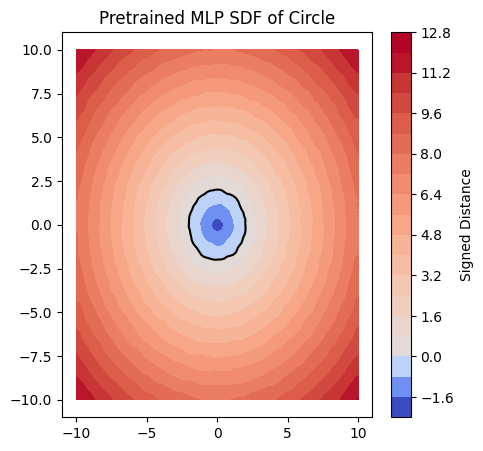

In [19]:
import matplotlib
import os

model = mlp.Decoder(multires=multires, input_dims=2).to(device)
model_path = '../models_resources/pretrained_circle.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('loaded model')
else:
    print("no model found, pretraining")
    model.pre_train_circle(3000, radius=1.0)
    torch.save(model.state_dict(),model_path)

#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = sdf.plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")
plt.title("Pretrained MLP SDF of Circle")
plt.xlim(-11, 11)
plt.ylim(-11, 11)

plt.show()

Voronoi ridges:  [[4 0]
 [4 9]
 [4 3]
 [5 6]
 [5 8]
 [5 0]
 [5 3]
 [3 0]
 [1 6]
 [1 8]
 [1 7]
 [8 6]
 [2 0]
 [2 9]
 [2 6]
 [2 7]
 [0 9]
 [0 6]
 [6 7]]
Voronoi rigdes vertices:  [[0, 1], [-1, 0], [-1, 1], [3, 4], [-1, 3], [4, 5], [-1, 5], [1, 5], [2, 6], [-1, 2], [-1, 6], [2, 3], [7, 8], [-1, 7], [8, 9], [-1, 9], [0, 7], [4, 8], [6, 9]]
Voronoi vertices:  [[-2.48095594 -1.5776068 ]
 [-2.61575117  1.50775578]
 [ 2.56792482  1.55894638]
 [ 1.67916587  2.09013449]
 [ 0.02710892  1.45665676]
 [-1.64502617  2.10916052]
 [ 2.57083801 -1.52494723]
 [-1.70194627 -2.04681971]
 [-0.00560474 -1.42780857]
 [ 1.63241768 -2.08336466]]
Delaunay simplices:  [[9 0 4]
 [0 3 4]
 [8 6 1]
 [5 6 8]
 [6 5 0]
 [5 3 0]
 [6 7 1]
 [2 0 9]
 [2 6 0]
 [2 7 6]]


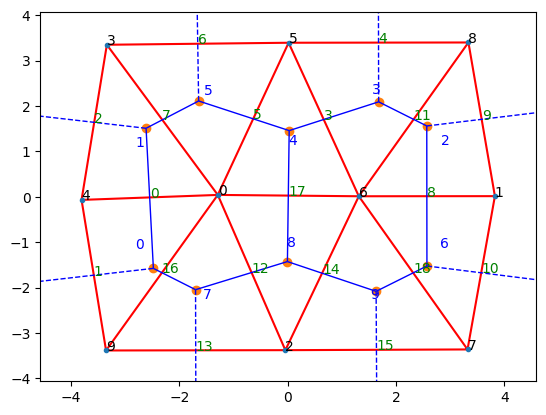

In [20]:

import numpy as np
from scipy.spatial import Delaunay, Voronoi
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import sdfpred_utils.sdfpred_utils as su



points = np.array([[-1.29121883, 0.04024019],
 [ 3.82579886,  0.01307893],
 [-0.0435634,  -3.37884161],
 [-3.34000104,  3.34717147],
 [-3.80725371, -0.0696819 ],
 [ 0.01656605,  3.39162777],
 [ 1.31297362,  0.0107052 ],
 [ 3.32053027, -3.36299312],
 [ 3.33716388,  3.39748507],
 [-3.35475875, -3.38574726]])

#points = np.array(su.createCVTgrid(num_centroids=128).detach().cpu())

voronoi_initial = Voronoi(points[:,:2])

# Compute Delaunay triangulation
delaunay_triangulation = Delaunay(points[:,:2])

print("Voronoi ridges: ", voronoi_initial.ridge_points)
print("Voronoi rigdes vertices: ", voronoi_initial.ridge_vertices)
print("Voronoi vertices: ", voronoi_initial.vertices)
print("Delaunay simplices: ", delaunay_triangulation.simplices)


fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=True, line_colors='blue')
#plot points index
for i, point in enumerate(points):
    ax.text(point[0], point[1], str(i), color='black')
    #plot points coordinates
    #ax.text(point[0], point[1], f"({point[0]:.2f}, {point[1]:.2f})", color='pink')

#plot the delaunay simplices with index
for i, simplex in enumerate(delaunay_triangulation.simplices):
    # Compute the circumcenter of the simplex
    circumcenter = np.mean(points[simplex], axis=0)
    ax.text(circumcenter[0], circumcenter[1], str(i), color='blue')

# plot the ridge points with index
for i, (point1, point2) in enumerate(voronoi_initial.ridge_points):
    # Compute the midpoint of the ridge
    midpoint = (points[point1] + points[point2]) / 2
    ax.text(midpoint[0], midpoint[1], str(i), color='green')




# # Plot the points
# plt.scatter(points[:, 0], points[:, 1], color='blue')
# #change color of point 0
# plt.scatter(points[0, 0], points[0, 1], color='red')
# Plot the Delaunay triangulation
ax.triplot(points[:, 0], points[:, 1], delaunay_triangulation.simplices, color='red')
# plt.xlim(-6, 6)
# plt.ylim(-6, 6)
plt.show()

In [36]:
ridges = voronoi_initial.ridge_points
ridges_vertices = voronoi_initial.ridge_vertices
vertices = voronoi_initial.vertices
simplices = delaunay_triangulation.simplices

sdf_values = model(torch.tensor(points, device=device))  # Assuming model outputs (N, 1) or (N,) tensor

# fix this as its the good way to do it
neighbors = torch.tensor(np.array(ridges), device=device)
all_tetrahedra = torch.tensor(np.array(simplices), device=device)

# Extract the SDF values for each site in the pair
sdf_i = sdf_values[neighbors[:, 0]]  # First site in each pair
sdf_j = sdf_values[neighbors[:, 1]]  # Second site in each pair
# Find the indices where SDF values have opposing signs or one is zero
mask = (sdf_i * sdf_j <= 0).squeeze()
zero_crossing_pairs = neighbors[mask]

print("zero_crossing_pairs_TORCH", zero_crossing_pairs)

# all_ridge_vertices = torch.tensor(np.array(ridges_vertices), device=device)
# ridge_vertices_pairs = all_ridge_vertices[mask]

# # from ridge_vertices_pairs create a neighbours list
# keys = torch.unique(ridge_vertices_pairs)

# #for each key append the index of the other key if present in the pair
# neighbours_dict = {}
# for key in keys:
#     neighbours_dict[key.item()] = []

# for i, pair in enumerate(ridge_vertices_pairs):

# print(neighbours_dict)


zero_crossing_pairs_TORCH tensor([[4, 0],
        [5, 6],
        [5, 0],
        [3, 0],
        [1, 6],
        [8, 6],
        [2, 0],
        [2, 6],
        [0, 9],
        [6, 7]], dtype=torch.int32)


In [22]:
zero_crossing_vertices_index = []
#convert tensor to np array
zero_crossing_pairs_list = zero_crossing_pairs.cpu().detach().numpy()

for triplet in simplices:
    triplet_pairs = {(triplet[0], triplet[1]), (triplet[1], triplet[2]), (triplet[0], triplet[2])}
    if any(pair in zero_crossing_pairs_list for pair in triplet_pairs):
        zero_crossing_vertices_index.append(triplet)
#####################
# vectorized version
simplices_tensor = torch.tensor(simplices, device = device)  # Shape: (M, 3)
sdf_i = sdf_values[simplices_tensor[:, 0]]  # First site in each pair
sdf_j = sdf_values[simplices_tensor[:, 1]]  # Second site in each pair
sdf_k = sdf_values[simplices_tensor[:, 2]]  # Third site in each pair
# Find the indices where SDF values have opposing signs or one is zero
mask = (sdf_i * sdf_j <= 0).squeeze() | (sdf_i * sdf_k <= 0).squeeze() | (sdf_j * sdf_k <= 0).squeeze()
print("mask", mask)
zero_crossing_vertices_index_vectorized = simplices_tensor[mask]
#######################

computed_v = su.compute_all_vertices(torch.tensor(points, device=device), zero_crossing_vertices_index)
vectorized_v = su.compute_vertices_2d_vectorized(torch.tensor(points, device=device),zero_crossing_vertices_index_vectorized)
#compare both arrays to see if they are the same
# must trim to 3 decimals to compare
#vertices = np.around(vertices, 3)
computed_v = computed_v.detach().cpu().numpy()
computed_v = np.around(computed_v, 3)
vectorized_v = vectorized_v.detach().cpu().numpy()
vectorized_v = np.around(vectorized_v, 3)

print("Computed vertices length: ", len(computed_v))
print("Vectorized vertices length: ", len(vectorized_v))
print("Vectorized_V and Computed_V: ", np.array_equal(vectorized_v, computed_v))

mask tensor([True, True, True, True, True, True, True, True, True, True])
Computed vertices length:  10
Vectorized vertices length:  10
Vectorized_V and Computed_V:  True


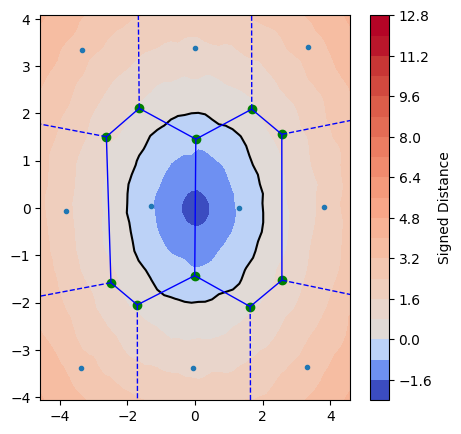

In [23]:
#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = sdf.plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")

voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
#plot points index
for i, point in enumerate(points):
    #ax.text(point[0], point[1], str(i), color='black')
    #plot points coordinates
    #ax.text(point[0], point[1], f"({point[0]:.2f}, {point[1]:.2f})", color='pink')
    continue

#plot the delaunay simplices with index
for i, simplex in enumerate(delaunay_triangulation.simplices):
    #Compute the circumcenter of the simplex
    circumcenter = np.mean(points[simplex], axis=0)
    #ax.text(circumcenter[0], circumcenter[1], str(i), color='blue')

#plot the ridge points with index
for i, (point1, point2) in enumerate(voronoi_initial.ridge_points):
    #Compute the midpoint of the ridge
    midpoint = (points[point1] + points[point2]) / 2
    #ax.text(midpoint[0], midpoint[1], str(i), color='green')


#Plot the Delaunay triangulation
#ax.triplot(points[:, 0], points[:, 1], delaunay_triangulation.simplices, color='red')

#scatter vectorized_v
plt.scatter(vectorized_v[:, 0], vectorized_v[:, 1], color='green')
# scatter computed
#plt.scatter(computed_v[:, 0], computed_v[:, 1], color='yellow')

plt.show()

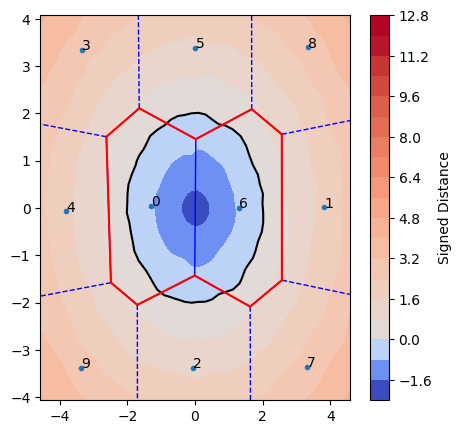

In [24]:
#Meshing test

#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = sdf.plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")

voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
#plot points index
for i, point in enumerate(points):
    ax.text(point[0], point[1], str(i), color='black')
    #plot points coordinates
    #ax.text(point[0], point[1], f"({point[0]:.2f}, {point[1]:.2f})", color='pink')
    continue

#plot the delaunay simplices with index
for i, simplex in enumerate(delaunay_triangulation.simplices):
    #Compute the circumcenter of the simplex
    circumcenter = np.mean(points[simplex], axis=0)
    #ax.text(circumcenter[0], circumcenter[1], str(i), color='blue')

#plot the ridge points with index
for i, (point1, point2) in enumerate(voronoi_initial.ridge_points):
    #Compute the midpoint of the ridge
    midpoint = (points[point1] + points[point2]) / 2
    #ax.text(midpoint[0], midpoint[1], str(i), color='green')


ridges = voronoi_initial.ridge_points
ridges_vertices = voronoi_initial.ridge_vertices
vertices = voronoi_initial.vertices
simplices = delaunay_triangulation.simplices

sdf_values = model(torch.tensor(points, device=device))  # Assuming model outputs (N, 1) or (N,) tensor

# Compute the Delaunay tessellation
tri = Delaunay(points)
vor = Voronoi(points)


neighbors = torch.tensor(np.array(vor.ridge_points), device=device)
neighbors_vertices = torch.tensor(np.array(vor.ridge_vertices), device=device)
#all_tetrahedra = torch.tensor(np.array(tri.simplices), device=device)

# Extract the SDF values for each site in the pair
sdf_i = sdf_values[neighbors[:, 0]]  # First site in each pair
sdf_j = sdf_values[neighbors[:, 1]]  # Second site in each pair
# Find the indices where SDF values have opposing signs or one is zero
mask_zero_crossing_sites = (sdf_i * sdf_j <= 0).squeeze()
zero_crossing_pairs = neighbors[mask_zero_crossing_sites]
faces = neighbors_vertices[mask_zero_crossing_sites]
faces = faces.cpu().detach().numpy()
mesh_vertices = voronoi_initial.vertices

#print(faces)
#print(mesh_vertices)

for face in faces:
#connect the two vertices in face
    plt.plot([mesh_vertices[face[0]][0], mesh_vertices[face[1]][0]], [mesh_vertices[face[0]][1], mesh_vertices[face[1]][1]], 'r-')


def get_zero_crossing_mesh_3d(sites, model):
    sites_np = sites.detach().cpu().numpy()
    vor = Voronoi(sites_np)  # Compute 3D Voronoi diagram

    sdf_values = model(sites)[:, 0].detach().cpu().numpy()  # Compute SDF values

    valid_faces = []  # List of polygonal faces
    used_vertices = set()  # Set of indices for valid vertices

    for (point1, point2), ridge_vertices in zip(vor.ridge_points, vor.ridge_vertices):
        if -1 in ridge_vertices:
            continue  # Skip infinite ridges

        # Check if SDF changes sign across this ridge
        if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
            valid_faces.append(ridge_vertices)
            used_vertices.update(ridge_vertices)

    # **Filter Voronoi vertices**
    used_vertices = sorted(used_vertices)  # Keep unique, sorted indices
    vertex_map = {old_idx: new_idx for new_idx, old_idx in enumerate(used_vertices)}
    filtered_vertices = vor.vertices[used_vertices]

    # **Re-index faces to match the new filtered vertex list**
    filtered_faces = [[vertex_map[v] for v in face] for face in valid_faces]

    return filtered_vertices, filtered_faces

vert, face = get_zero_crossing_mesh_3d(torch.tensor(points, device=device), model)

# for face in faces: # Plot each face
#     plt.plot([vert[face[0]][0], vert[face[1]][0]], [vert[face[0]][1], vert[face[1]][1]], 'g-')


plt.show()

In [25]:
#Todo vectorize
def compute_cvt_loss(sites, model):
    # Convert sites to NumPy for Voronoi computation
    sites_np = sites.detach().cpu().numpy()
    vor = Voronoi(sites_np)
    sdf_values = model(sites)
    

    centroids = []
    valid_indices = []

    for i in range(len(sites_np)):
        region_index = vor.point_region[i]
        region = vor.regions[region_index]

        # Ensure the region is valid (finite and non-empty)
        if region and -1 not in region:
            vertices = vor.vertices[region]
            centroid = vertices.mean(axis=0)  # Compute centroid
            centroids.append(centroid)
            valid_indices.append(i)  # Store indices of valid centroids

    # Convert centroids to a PyTorch tensor
    centroids = torch.tensor(np.array(centroids), device=sites.device, dtype=sites.dtype)

    # Select only valid sites for loss computation
    valid_sites = sites[valid_indices]
    
    
    sdf_weights = 1 / (1 + torch.abs(sdf_values[valid_indices]))

    # Compute Mean Squared Error (MSE) loss
    #cvt_loss = torch.mean(torch.norm(valid_sites - centroids, p=2, dim=1) ** 2)
    cvt_loss = torch.mean(((valid_sites - centroids)*sdf_weights)**2)
    
    print("cvt_loss: ", cvt_loss)
    return cvt_loss

def compute_cvt_loss_vectorized(sites, model):
    # Convert sites to NumPy for Voronoi computation
    sdf_values = model(sites)
    sites_np = sites.detach().cpu().numpy()
    vor = Voronoi(sites_np)
        
    # create a nested list of vertices for each site
    centroids = [vor.vertices[vor.regions[vor.point_region[i]]].mean(axis=0) for i in range(len(sites_np)) if vor.regions[vor.point_region[i]] and -1 not in vor.regions[vor.point_region[i]]]
    centroids = torch.tensor(np.array(centroids), device=sites.device, dtype=sites.dtype)
    valid_indices = torch.tensor([i for i in range(len(sites_np)) if vor.regions[vor.point_region[i]] and -1 not in vor.regions[vor.point_region[i]]], device=sites.device)
    
    valid_sites = sites[valid_indices]
    sdf_weights = 1 / (1 + torch.abs(sdf_values[valid_indices]))
    
    cvt_loss = torch.mean(((valid_sites - centroids)*sdf_weights)**2)
    
    print("cvt_loss: ", cvt_loss)
    return cvt_loss

import cProfile, pstats
import time
profiler = cProfile.Profile()
profiler.enable()

cvt_loss = compute_cvt_loss(torch.tensor(points, device=device), model)
cvt_loss_vectorized = compute_cvt_loss_vectorized(torch.tensor(points, device=device), model)

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()

cvt_loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
cvt_loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
         880 function calls (854 primitive calls) in 0.004 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    0.004    0.001 /home/wylliam/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3490(run_code)
        3    0.000    0.000    0.004    0.001 {built-in method builtins.exec}
        1    0.000    0.000    0.002    0.002 /tmp/ipykernel_126056/1883951781.py:63(<module>)
        1    0.000    0.000    0.002    0.002 /tmp/ipykernel_126056/1883951781.py:2(compute_cvt_loss)
        1    0.000    0.000    0.001    0.001 /tmp/ipykernel_126056/1883951781.py:64(<module>)
        1    0.000    0.000    0.001    0.001 /tmp/ipykernel_126056/1883951781.py:39(compute_cvt_loss_vectorized)
        2    0.000    0.000    0.001    0.001 {built-in method builtins.print}
  